# Meta-Modelo Random Forest (Ensamble Stacking)

**Autor:** Pablo Spínola López

**Descripción:** Este notebook realiza el desarrollo, entrenamiento y evaluación del meta modelo Random Forest, recopilando y aprendiendo de los 5 modelos base, utilizando distintas técnicas como el ajuste de hiperparámetros con GridSearch, validación cruzada estratificada (Stratified K-Fold), y análisis comparativo mediante métricas como AUC, TPR, FPR, curvas ROC y curvas de pérdida.

Importación de todas las librerías necesarias para el entrenamiento

In [1]:
#LIBRERÍAS UTILIZADAS

# Acceso a archivos
import sys
import os

# Visualización de métricas
import matplotlib.pyplot as plt

# Librería que divide en test y train el dataset, permite usar un stratified K-Fold, con la finalidad de revisar hiperparámetros
from sklearn.model_selection import GridSearchCV, StratifiedKFold

from sklearn.ensemble import RandomForestClassifier

Importamos las funciones centralizadas

In [2]:
#FUNCIONES PERSONALIZADAS PARA LOS MODELOS
sys.path.append(os.path.abspath("../funciones"))

#IMPORAR FUNCIONES AUXILIARES PERSONALIZADAS DE ENTRENAMIENTO GENERAL DESDE EL MÓDULO
from funcionesEntrenamiento import (
    cargar_datos_entrenamiento,
    cargar_datos_prueba,
    imprimir_forma,
    division_train_val,
    reporte_clasificacion,
    crear_matriz_confusion,
    calcular_roc_auc,
    metricas_tpr_fpr,
    hacer_pepinillo
)

#IMPORAR FUNCIONES AUXILIARES PERSONALIZADAS DE ENTRENAMIENTO PARA ENSAMBLE DESDE EL MÓDULO
from funcionesEntrenamientoEnsamble import (
    parametros_4_oof,
    predicciones_de_modelos,
    probar_ensamble
)

In [3]:
#CARGA Y PREPARACIÓN DE DATOS DE ENTRENAMIENTO
X, y = cargar_datos_entrenamiento()

shape, head = imprimir_forma(X)
print("Shape: ", shape)
head

Shape:  (1500, 1568)


,longitud_texto,num_palabras,comida,restriccion,purga,imagen_corporal,ejercicio,polaridad,subjetividad,tag_Anorexia,...,tfidf_1490,tfidf_1491,tfidf_1492,tfidf_1493,tfidf_1494,tfidf_1495,tfidf_1496,tfidf_1497,tfidf_1498,tfidf_1499
0,0.238798,-0.062255,0,0,0,0,0,1.168716,0.355986,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.536538,-1.607600,0,0,0,0,0,-0.346445,-1.134095,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.453282,-0.283019,3,2,0,0,0,0.789926,0.952018,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.329069,0.158508,0,0,0,1,0,1.774781,0.654002,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.784277,-0.724546,0,0,0,1,0,-1.331300,0.952018,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
#CARGA Y PREPARACIÓN DE DATOS DE PRUEBA
X_test, y_test = cargar_datos_prueba()

shape_test, head_test = imprimir_forma(X_test)
print("Shape test: ", shape_test)
head_test

Shape test:  (250, 1568)


,longitud_texto,num_palabras,comida,restriccion,purga,imagen_corporal,ejercicio,polaridad,subjetividad,tag_Anorexia,...,tfidf_1490,tfidf_1491,tfidf_1492,tfidf_1493,tfidf_1494,tfidf_1495,tfidf_1496,tfidf_1497,tfidf_1498,tfidf_1499
0,-0.393101,-0.503783,0,1,0,0,0,0.966695,1.349373,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.315037,2.366144,0,1,0,1,1,-0.194929,0.542246,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.874548,-0.724546,2,2,0,0,0,-0.346445,-1.134095,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.178617,-0.283019,1,3,0,1,0,-0.346445,-1.134095,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.315037,3.249199,1,3,0,0,0,-0.346445,-1.134095,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
#DIVISIÓN PARA EL ENTRENAMIENTO/VALIDACIÓN
X_train, X_val, y_train, y_val = division_train_val(X, y)

train_shape, _ = imprimir_forma(X_train)
val_shape, _ = imprimir_forma(X_val)
print(f"Forma de conjunto de entrenamiento:", train_shape)
print(f"Forma de conjunto de validación:", val_shape)

Forma de conjunto de entrenamiento: (1200, 1568)
Forma de conjunto de validación: (300, 1568)


## Entrenamiento inicial de Meta Modelo

Creamos un objeto de stratified k-fold y un arreglo de ceros para las predicciones

In [6]:
skf, oof_preds = parametros_4_oof(X_train)

Realizamos las predicciones OOF del conjunto de entrenamiento con nuestros modelos base para entrenarlos.

In [7]:
oof_preds = predicciones_de_modelos(X_train, y_train, skf, oof_preds)

Generando predicciones OOF para el modelo de MLP...


c:\Users\saaso\miniconda3\envs\ia-env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\saaso\miniconda3\envs\ia-env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\saaso\miniconda3\envs\ia-env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\saaso\miniconda3\envs\ia-env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\saaso\miniconda

Generando predicciones OOF para el modelo de PAC...
Generando predicciones OOF para el modelo de RF...
Generando predicciones OOF para el modelo de SVM...
Generando predicciones OOF para el modelo de XGB...


In [8]:
mm_inicial = RandomForestClassifier(random_state=22)
mm_inicial.fit(oof_preds, y_train)

RandomForestClassifier(random_state=22)

Se realizan predicciones del conjunto de pruebas para poblar el dataset ensamblado.

In [9]:
X_meta_test = probar_ensamble(X_test)

In [10]:
# Validación de modelo inicial y cálculo de métricas de evaluación
y_pred_test, y_proba_test, reporte_test = reporte_clasificacion(X_meta_test, y_test, mm_inicial)

print("Classification Report:")
print(reporte_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.75      0.79       116
           1       0.80      0.88      0.84       134

    accuracy                           0.82       250
   macro avg       0.82      0.82      0.82       250
weighted avg       0.82      0.82      0.82       250



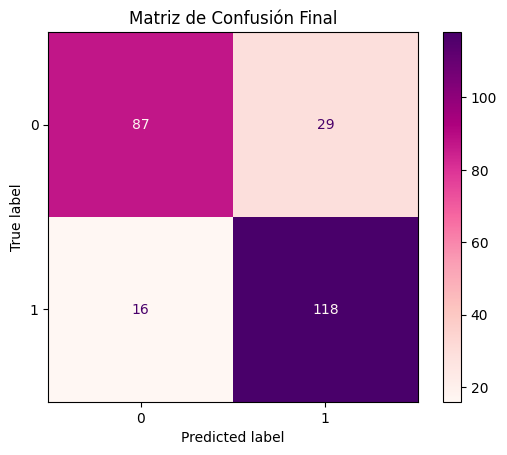

In [11]:
# Matriz de confusión
cm_test, disp_test = crear_matriz_confusion(y_test, y_pred_test)
disp_test.plot(cmap='RdPu')
plt.title("Matriz de Confusión Final")
plt.show()

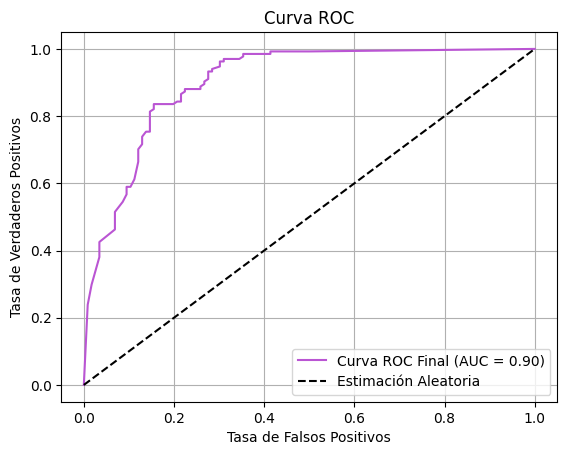

In [12]:
# Predicciones de probabilidad (para curva ROC)
fpr_test, tpr_test, thresholds_test, auc_score_test = calcular_roc_auc(y_test, y_proba_test)

# Gráfica ROC
plt.figure()
plt.plot(fpr_test, tpr_test, color='mediumorchid', label=f"Curva ROC Final (AUC = {auc_score_test:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Estimación Aleatoria")
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [13]:
# Cálculo de métricas de desempeño de la matriz de confusión
TPR_test, FPR_test = metricas_tpr_fpr(cm_test)

# Mostrar métricas
print(f"AUC: {(auc_score_test * 100):.4f}")
print(f"TPR (True Positive Rate): {(TPR_test * 100):.4f}")
print(f"FPR (False Positive Rate): {(FPR_test * 100):.4f}")

AUC: 90.1795
TPR (True Positive Rate): 88.0597
FPR (False Positive Rate): 25.0000


## Búsqueda de mejores parámetros (Entrenamiento y Validación)

In [ ]:
# Modelo base para encontrar mejores parámetros
mm = RandomForestClassifier(random_state=22)

# Parámetros a buscar con GridSearchSV  
param_grid = {
    'criterion' : ['entropy', 'gini', 'log_loss'],
    'max_depth' : [2, 3, 4, 5],
    'max_features' : ['sqrt', 'log2', None],
    'min_samples_leaf' : [3, 4, 5, 6],
    'min_samples_split' : [2, 3, 4, 5],
    'n_estimators' : [490, 500, 510, 520],
    'class_weight' : ["balanced", "balanced_subsample"],
    'monotonic_cst' : [[1, 0, 1, -1, -1], [1, 0, 1, 0, 0]],
}

# Cross-validation estratificada
cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=22
)

# GridSearch
grid_search = GridSearchCV(
    estimator=mm,
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=3,
    error_score='raise'
)

In [499]:
grid_search.fit(oof_preds, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=22, shuffle=True),
             error_score='raise',
             estimator=RandomForestClassifier(random_state=22), n_jobs=-1,
             param_grid={'class_weight': ['balanced'], 'criterion': ['entropy'],
                         'max_depth': [3], 'max_features': ['sqrt'],
                         'min_samples_leaf': [5], 'min_samples_split': [2],
                         'monotonic_cst': [[1, 0, 1, -1, -1]],
                         'n_estimators': [510]},
             scoring='roc_auc', verbose=3)

In [500]:
grid_search.best_params_

{'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 3,
 'max_features': 'sqrt',
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'monotonic_cst': [1, 0, 1, -1, -1],
 'n_estimators': 510}

## Modelo Final (Entrenamiento y Prueba)

In [537]:
# Creación de modelo con los mejores parámetros
best_mm = RandomForestClassifier(
    criterion = 'entropy',
    max_depth = 3,
    max_features = 'sqrt',
    min_samples_leaf = 5,
    min_samples_split = 2,
    n_estimators = 510,
    class_weight = "balanced",
    monotonic_cst = [1, 0, 1, -1, -1],
    random_state = 22
)

best_mm.fit(oof_preds, y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=3, min_samples_leaf=5,
                       monotonic_cst=[1, 0, 1, -1, -1], n_estimators=510,
                       random_state=22)

In [538]:
# Validación del modelo
y_pred_test, y_proba_test, reporte_test = reporte_clasificacion(X_meta_test, y_test, best_mm)

print("Classification Report:")
print(reporte_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.76      0.82       116
           1       0.81      0.92      0.86       134

    accuracy                           0.84       250
   macro avg       0.85      0.84      0.84       250
weighted avg       0.85      0.84      0.84       250



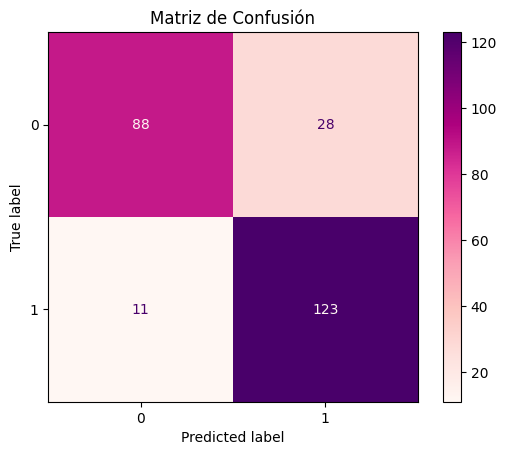

In [539]:
# Matriz de confusión
cm, disp = crear_matriz_confusion(y_test, y_pred_test)
disp.plot(cmap='RdPu')
plt.title("Matriz de Confusión")
plt.show()

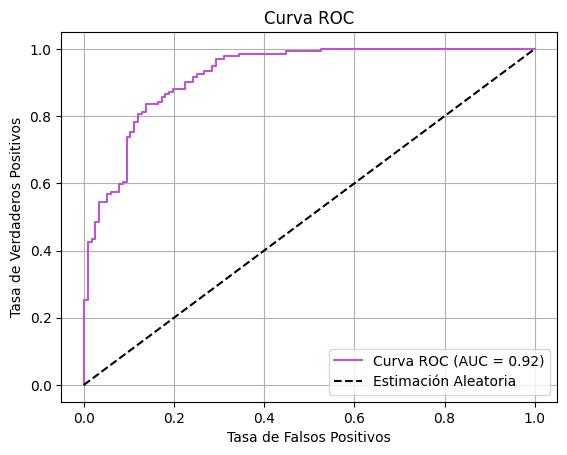

In [540]:
# Predicciones de probabilidad (para curva ROC)
fpr, tpr, thresholds, auc_score = calcular_roc_auc(y_test, y_proba_test)

# Gráfica de ROC
plt.figure()
plt.plot(fpr, tpr, color='mediumorchid', label=f"Curva ROC (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Estimación Aleatoria")
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [541]:
# Cálculo de métricas de desempeño de la matriz de confusión
TPR, FPR = metricas_tpr_fpr(cm)

# Mostrar métricas
print(f"AUC: {(auc_score * 100):.4f}")
print(f"TPR (Tasa de Positivos Verdaderos): {(TPR * 100):.4f}")
print(f"FPR (Tasa de Falsos Positivos): {(FPR * 100):.4f}")

AUC: 92.3121
TPR (Tasa de Positivos Verdaderos): 91.7910
FPR (Tasa de Falsos Positivos): 24.1379


In [542]:
# Guardado del modelo final en un archivo pickle
hacer_pepinillo(best_mm, "metaModelEns.pkl")